# Single halo inference

In the case we are able to use the kinematic to isolate the star of a given dwarf galaxy, we can use CASBI also to make inference on a single dwarf galaxy. Let's begin by training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
import torch

import os

from ili.validation.metrics import PosteriorCoverage
from ili.dataloaders import NumpyLoader, TorchLoader
from ili.inference import InferenceRunner
import CASBI.inference as inference
from CASBI.inference import CustomDataset_subhalo
from CASBI.utils.CNN import ConvNet_subhalo
import CASBI.create_template_library as ctl


2025-01-21 16:46:08.772178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737474368.792591 1208251 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737474368.798484 1208251 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 16:46:08.817070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
#path to the files generetated by the CASBI.preprocessing
data_path = "/export/data/vgiusepp/casbi_rewriting"

galaxy_file_path = os.path.join(data_path, "new_files/")
dataframe_path = os.path.join(data_path, "dataframe.parquet")
preprocessing_path = os.path.join(data_path, "preprocess_file.npz")

#generate template library
sigma = 0.
device = 'cuda'

template_library = ctl.TemplateLibrary(galaxy_file_path=galaxy_file_path, 
                                       dataframe_path=dataframe_path, 
                                       preprocessing_path=preprocessing_path, 
                                       M_tot=6*1e9,
                                       sigma=sigma)    
template_library.create_single_halo_library(test_percentage=0.1, random_state=43)

In [10]:
len(template_library.x_train)

4546

let's visualise a single galaxy chemical abundance

/tmp/ipykernel_1208251/1746697711.py:4: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(observable.T),


Text(0, 0.5, '[O/Fe]')

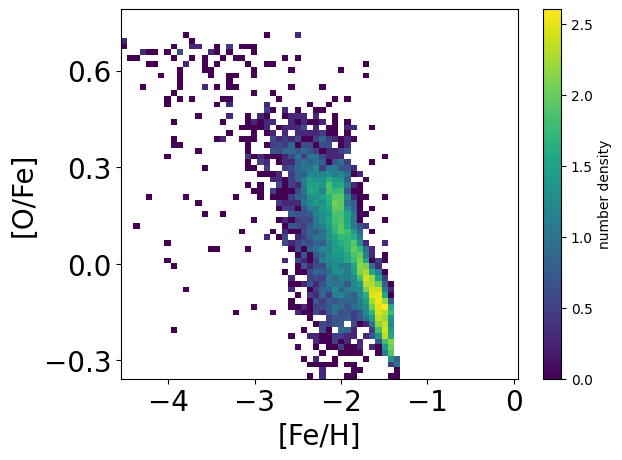

In [11]:
observable = template_library.x_train[2]

fig, ax = plt.subplots()
im = ax.imshow(np.log10(observable.T), 
           extent = [template_library.feh_lim[0], template_library.feh_lim[1], template_library.ofe_lim[0], template_library.ofe_lim[1]], 
           origin='lower', 
           cmap='viridis',
           aspect='auto')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('number density')

# Set the maximum number of ticks on the x and y axes to 4
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=4))


ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('[Fe/H]', fontsize=20)
ax.set_ylabel('[O/Fe]', fontsize=20)

In [12]:
x_train, params_train, x_test, params_test = template_library.get_inference_input()
x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)
params_train = torch.tensor(params_train, dtype=torch.float32)  # Shape: (batch, 2)
params_test = torch.tensor(params_test, dtype=torch.float32)  # Shape: (batch, 2)

/tmp/ipykernel_1208251/809114441.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)
/tmp/ipykernel_1208251/809114441.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)
/tmp/ipykernel_1208251/809114441.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params_train = torch.tensor(params_train, dtype=torch.float32)  # Shape: (batch, 2)
/tmp/ipykernel_12

In [13]:
posterior_ensamble, summaries = inference.train_inference(x=x_train.to('cuda'), 
                                                          theta=params_train.to('cuda'), 
                                                          learning_rate=1e-4, 
                                                          model='nsf',
                                                          N_nets=6,
                                                          hidden_feature=100,
                                                          num_transforms=30,
                                                          output_dir=f'./posterior/posterior_{sigma}', 
                                                          batch_size=256*8,
                                                          embedding_net= ConvNet_subhalo(output_dim=32),
                                                          custom_dataset = CustomDataset_subhalo,
                                                          device='cuda',
                                                          validation_fraction=0.45,
                                                          norm_x=True,)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 6.
65 epochs [00:34,  1.91 epochs/s, loss=-0.331, loss_val=0.898] 
INFO:root:Training model 2 / 6.
133 epochs [01:07,  1.98 epochs/s, loss=-1.16, loss_val=-0.0503] 
INFO:root:Training model 3 / 6.
207 epochs [01:41,  2.04 epochs/s, loss=-1.57, loss_val=0.0907] 
INFO:root:Training model 4 / 6.
147 epochs [01:12,  2.03 epochs/s, loss=-1.29, loss_val=0.0453] 
INFO:root:Training model 5 / 6.
81 epochs [00:39,  2.03 epochs/s, loss=-0.661, loss_val=0.964]
INFO:root:Training model 6 / 6.
91 epochs [00:45,  1.99 epochs/s, loss=-0.772, loss_val=0.733] 
INFO:root:It took 373.1070022583008 seconds to train models.
INFO:root:Saving model to posterior/posterior_0.0


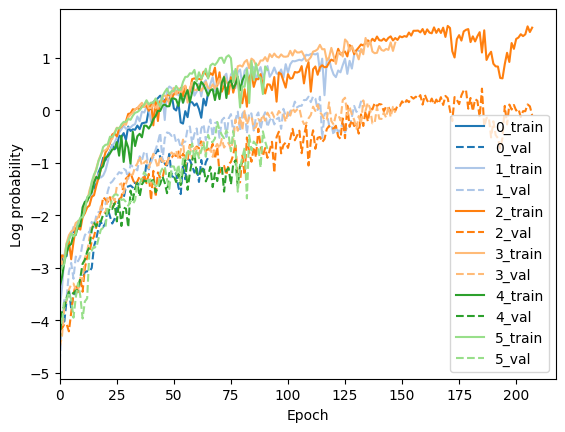

In [14]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, )
# c = list(mcolors.TABLEAU_COLORS)
colors =  list(plt.cm.tab20.colors)
c = [colors[j % len(colors)] for j in range(len(summaries))]
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

  6%|▌         | 28/506 [00:27<07:49,  1.02it/s]/export/home/vgiusepp/miniconda3/envs/fff/lib/python3.10/site-packages/ili/utils/ndes_pt.py:189: UserWarning: Direct sampling took too long. The posterior is poorly constrained within the prior support. Consider using emcee sampling or using a larger prior support. Returning prior samples.
  warnings.warn(
100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


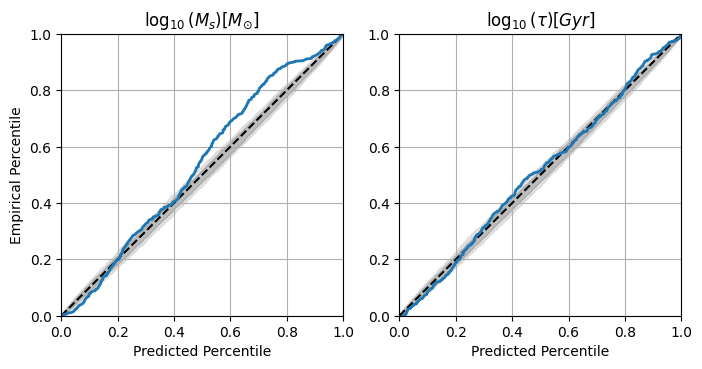

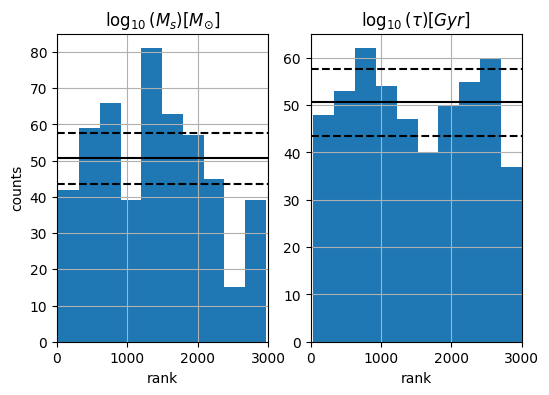

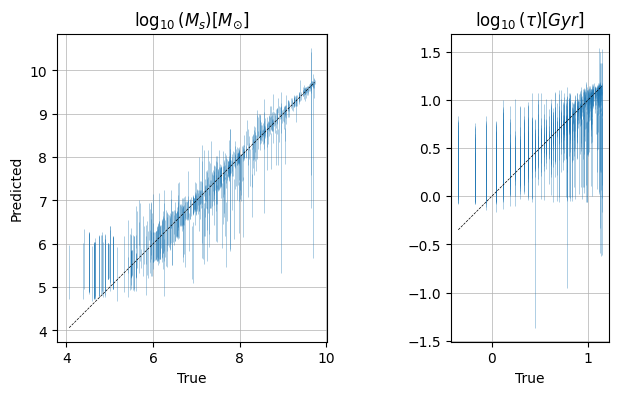

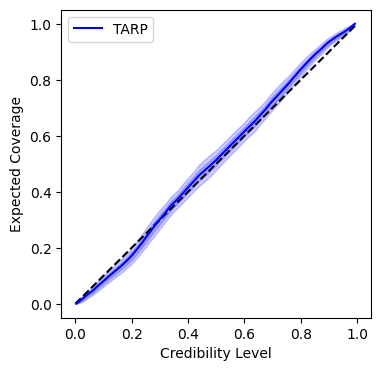

In [15]:
# x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)

plot_hist = ["coverage", "histogram", "predictions", "tarp"]
metric = PosteriorCoverage(
    num_samples=3_005, sample_method='direct',
    labels=[rf'$\log_{{10}}(M_{{s}}) [M_{{\odot}}]$', rf'$\log_{{10}}(\tau) [Gyr]$'], plot_list = plot_hist
)

fig = metric(
    posterior=posterior_ensamble,
    x=x_test, theta=params_test)

# The rank plot suggest that we are underestimating 
This could be due to the fact that the training set is imbalance 

Text(0.5, 0, 'star_age')

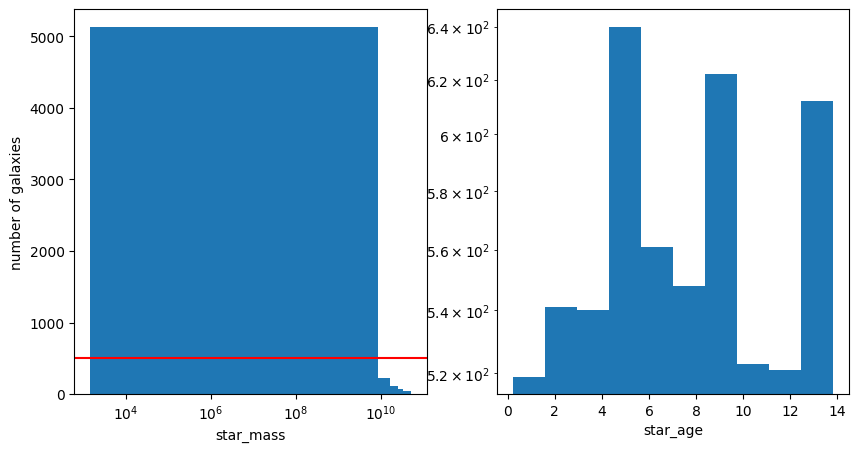

In [7]:
df = template_library.dataframe

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.hist(df['star_mass'], bins=6)
ax.axhline(500, c='r')
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('star_mass')
ax.set_ylabel('number of galaxies')

ax = fig.add_subplot(122)
ax.hist(df['infall_time'])
ax.set_yscale('log')
ax.set_xlabel('star_age')

As we can see this is not uniform and there are a very few galaxies with a massive star content (>10**9)

In [7]:
import pandas as pd

# Define the number of bins and how many samples you want per bin
num_bins = 6
samples_per_bin = 500

# Create bins
bins = np.linspace(df['star_mass'].min(), df['star_mass'].max(), num_bins + 1)
df['bin'] = np.digitize(df['star_mass'], bins)

# Uniform sampling
dfs = []
for b in range(1, num_bins + 1):
    bin_group = df[df['bin'] == b]
    if len(bin_group) == 0:
        continue
    # If not enough samples, resample with replacement
    dfs.append(bin_group.sample(samples_per_bin, replace=len(bin_group) < samples_per_bin))

df_uniform = pd.concat(dfs).sample(frac=1).drop(columns='bin').reset_index(drop=True)
print(df_uniform) 

         star_mass  infall_time     Galaxy_name   max_feh  max_ofe
0     1.755404e+09     6.058784  g5.55e11.00448 -0.619678  0.75673
1     1.837117e+09    10.374172  g2.54e11.00768 -0.727267  0.75673
2     4.185116e+09     5.411476  g7.66e11.00400 -0.717021  0.75673
3     3.804770e+07     1.096087  g3.71e11.00080 -1.656444  0.75673
4     4.559274e+09     5.411476  g2.57e11.00400 -0.160291  0.75673
...            ...          ...             ...       ...      ...
2995  5.070389e+09     8.216478  g3.71e11.00608 -0.126652  0.75673
2996  2.747528e+09     6.274553  g6.96e11.00464 -0.783306  0.75673
2997  1.683906e+09     9.726864  g1.37e11.00720 -0.329314  0.75673
2998  5.484179e+09    13.394944  g2.42e11.00992  0.045394  0.75673
2999  5.828070e+09    13.826483  g2.39e11.01024 -0.043029  0.75673

[3000 rows x 5 columns]


Text(0.5, 0, 'star_age')

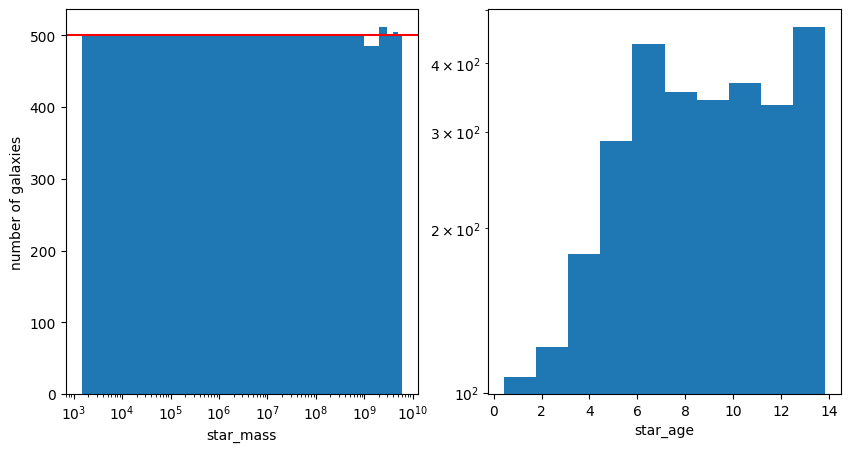

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.hist(df_uniform['star_mass'], bins=6)
ax.axhline(500, c='r')
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('star_mass')
ax.set_ylabel('number of galaxies')

ax = fig.add_subplot(122)
ax.hist(df_uniform['infall_time'])
ax.set_yscale('log')
ax.set_xlabel('star_age')

/tmp/ipykernel_3076711/1958278117.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rebalanced_data = grouped.apply(lambda x: x.sample(n=target_count, replace=len(x) < target_count)).reset_index(drop=True)


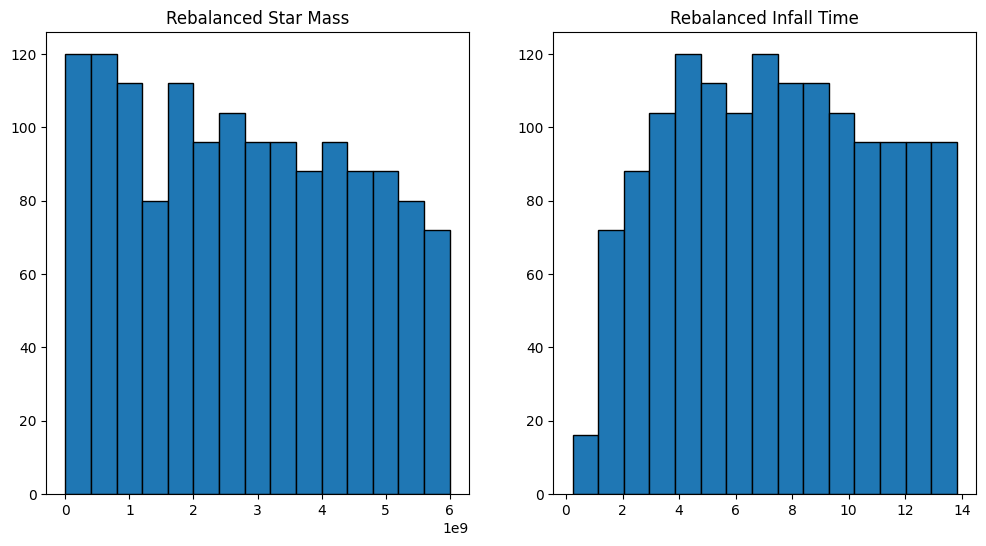

In [16]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt

data = df
# Step 1: Define bins for uniform distribution
num_bins = 15
star_mass_bins = np.linspace(data['star_mass'].min(), data['star_mass'].max(), num_bins + 1)
infall_time_bins = np.linspace(data['infall_time'].min(), data['infall_time'].max(), num_bins + 1)

# Step 2: Create bin labels
data['star_mass_bin'] = pd.cut(data['star_mass'], bins=star_mass_bins, labels=False)
data['infall_time_bin'] = pd.cut(data['infall_time'], bins=infall_time_bins, labels=False)

# Step 3: Rebalance by grouping
grouped = data.groupby(['star_mass_bin', 'infall_time_bin'])

# Step 4: Find the target count per bin
target_count = min(group.size for _, group in grouped)

# Step 5: Resample data
rebalanced_data = grouped.apply(lambda x: x.sample(n=target_count, replace=len(x) < target_count)).reset_index(drop=True)

# Step 6: Plot rebalanced histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(rebalanced_data['star_mass'], bins=star_mass_bins, edgecolor='k')
plt.title('Rebalanced Star Mass')

plt.subplot(1, 2, 2)
plt.hist(rebalanced_data['infall_time'], bins=infall_time_bins, edgecolor='k')
plt.title('Rebalanced Infall Time')
plt.show()


In [17]:
len(rebalanced_data)

1448

In [9]:
template_library_uniform = ctl.TemplateLibrary(galaxy_file_path=galaxy_file_path, 
                                       dataframe_path=dataframe_path, 
                                       preprocessing_path=preprocessing_path, 
                                       M_tot=6e9,
                                       sigma=sigma)    
template_library_uniform.dataframe = df_uniform
template_library_uniform.create_single_halo_library(test_percentage=0.1, random_state=43)

In [10]:
x_train, params_train, x_test, params_test = template_library_uniform.get_inference_input()


In [20]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

params_train = torch.tensor(params_train, dtype=torch.float32)
params_test = torch.tensor(params_test, dtype=torch.float32)

/tmp/ipykernel_3361439/2630784322.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_3361439/2630784322.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/tmp/ipykernel_3361439/2630784322.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params_train = torch.tensor(params_train, dtype=torch.float32)
/tmp/ipykernel_3361439/2630784322.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTe

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 8.
95 epochs [00:58,  1.63 epochs/s, loss=7.16, loss_val=7.1] 
INFO:root:Training model 2 / 8.
41 epochs [00:25,  1.59 epochs/s, loss=12.6, loss_val=13.4]
INFO:root:Training model 3 / 8.
45 epochs [00:27,  1.65 epochs/s, loss=10.4, loss_val=10.8]
INFO:root:Training model 4 / 8.
46 epochs [00:29,  1.59 epochs/s, loss=11.5, loss_val=12.1]
INFO:root:Training model 5 / 8.
31 epochs [00:20,  1.51 epochs/s, loss=10.9, loss_val=11.8]
INFO:root:Training model 6 / 8.
85 epochs [00:51,  1.64 epochs/s, loss=9.66, loss_val=9.95]
INFO:root:Training model 7 / 8.
197 epochs [01:59,  1.64 epochs/s, loss=8.46, loss_val=7.83]
INFO:root:Training model 8 / 8.
51 epochs [00:31,  1.62 epochs/s, loss=12.8, loss_val=12.9]
INFO:root:It took 366.07868099212646 seconds to train models.
INFO:root:Saving model to posterior/posterior_0.0


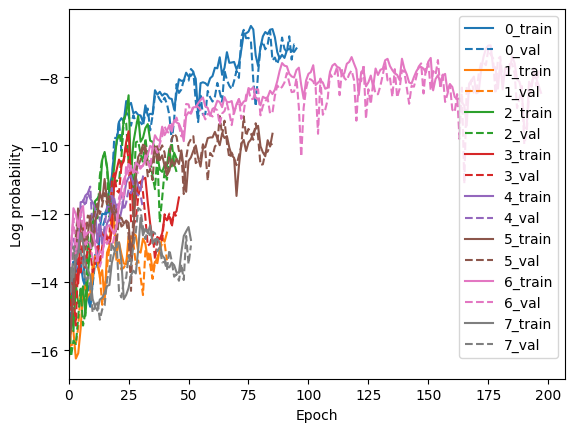

In [21]:


posterior_ensamble, summaries = inference.train_inference(x=x_train.to('cuda'), 
                                                          theta=params_train.to('cuda'), 
                                                          learning_rate=1e-4, 
                                                          model='nsf',
                                                          N_nets=8,
                                                          hidden_feature=40,
                                                          num_transforms=10,
                                                          output_dir=f'./posterior/posterior_{sigma}', 
                                                          batch_size=256,
                                                          embedding_net= ConvNet_subhalo(output_dim=32),
                                                          custom_dataset = CustomDataset_subhalo,
                                                          device='cuda',
                                                          validation_fraction=0.3,
                                                          norm_x=True,)
# plot train/validation loss
fig, ax = plt.subplots(1, 1, )
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()


  1%|          | 2/300 [00:01<02:33,  1.94it/s]/export/home/vgiusepp/miniconda3/envs/fff/lib/python3.10/site-packages/ili/utils/ndes_pt.py:189: UserWarning: Direct sampling took too long. The posterior is poorly constrained within the prior support. Consider using emcee sampling or using a larger prior support. Returning prior samples.
  warnings.warn(
100%|██████████| 100/100 [00:03<00:00, 31.16it/s]


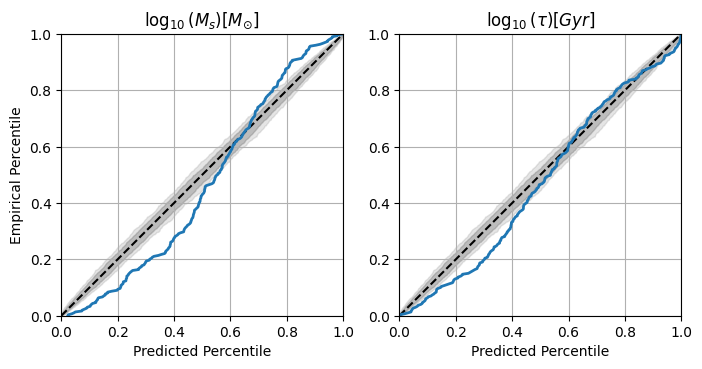

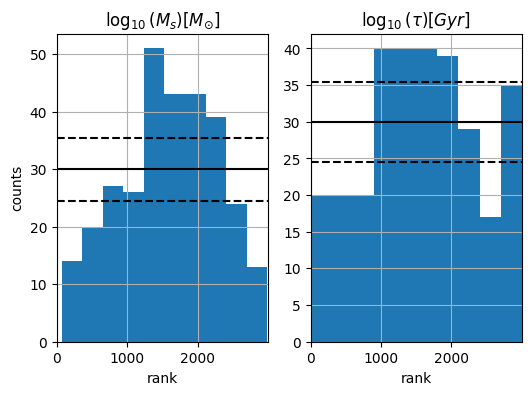

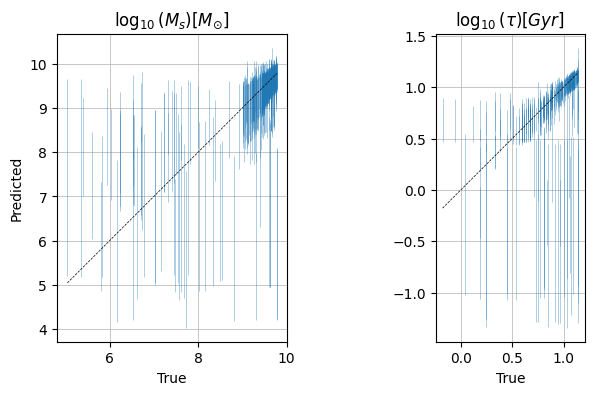

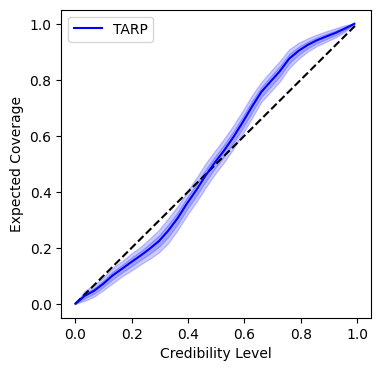

In [22]:

plot_hist = ["coverage", "histogram", "predictions", "tarp"]
metric = PosteriorCoverage(
    num_samples=3_001, sample_method='direct',
    labels=[rf'$\log_{{10}}(M_{{s}}) [M_{{\odot}}]$', rf'$\log_{{10}}(\tau) [Gyr]$'], plot_list = plot_hist
)

fig = metric(
    posterior=posterior_ensamble,
    x=x_test, theta=params_test)